# Getting 3hrly data for surface temp, and radiation variables
Need to get radiation variables and compare to the observations at summit station



### Questions: 
- Which experiment has the lowest surface temp bias?
- Why?
- In each model, which terms contribute the most to forcing?

In [63]:
# Import statements
import xarray as xr
xr.set_options(display_style='html')

import intake
from pathlib import Path
import statistics
import statsmodels.api as sm
import pickle
import numpy as np
import pandas as pd
from scipy.io import netcdf_file
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import zarr
import re
import cartopy
import seaborn as sns

data_path =  Path.home() / "repos/a500/" /'final/data/'

In [17]:
import os
# FILEPATH: /c:/Users/melis/repos/a500/final/final_cmip_3hr.ipynb
models_with_seb_variables_file = f'{data_path}/models_with_seb_variables.pickle'

data_exists = os.path.exists(models_with_seb_variables_file)
data_exists #= False

True

## Get CMIP model(s)

Pull the data from the sit itself and put into pandas df in order to be able to visualize it.

In [18]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [19]:
dataframe = col.df
threeHourlyModels = dataframe[col.df['table_id'].str.contains("3hr")]

In [20]:
threeHourlyModels

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
27,HighResMIP,MOHC,HadGEM3-GC31-MM,highresSST-present,r1i1p1f1,3hr,prc,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170818
38,HighResMIP,MOHC,HadGEM3-GC31-MM,highresSST-present,r1i1p1f1,3hr,pr,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170818
41,HighResMIP,MOHC,HadGEM3-GC31-MM,highresSST-present,r1i1p1f1,E3hr,psl,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170818
62,HighResMIP,MOHC,HadGEM3-GC31-HM,highresSST-present,r1i1p1f1,E3hr,psl,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170831
95,HighResMIP,MOHC,HadGEM3-GC31-HM,highresSST-present,r1i1p1f1,3hr,tas,gn,gs://cmip6/CMIP6/HighResMIP/MOHC/HadGEM3-GC31-...,NaN,20170831
...,...,...,...,...,...,...,...,...,...,...,...
503148,CMIP,CMCC,CMCC-ESM2,historical,r1i1p1f1,3hr,huss,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-ESM2/historica...,NaN,20210114
504939,ScenarioMIP,CMCC,CMCC-ESM2,ssp585,r1i1p1f1,3hr,vas,gn,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ss...,NaN,20210126
504940,ScenarioMIP,CMCC,CMCC-ESM2,ssp585,r1i1p1f1,3hr,uas,gn,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ss...,NaN,20210126
504941,ScenarioMIP,CMCC,CMCC-ESM2,ssp585,r1i1p1f1,3hr,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ss...,NaN,20210126


Look at the unique keys for all the entries in order to find the models we want

In [21]:
models = threeHourlyModels['source_id'].unique()
models

array(['HadGEM3-GC31-MM', 'HadGEM3-GC31-HM', 'HadGEM3-GC31-LM',
       'GFDL-ESM4', 'GFDL-CM4', 'GFDL-CM4C192', 'IPSL-CM6A-LR',
       'CNRM-CM6-1', 'GISS-E2-1-G', 'BCC-CSM2-MR', 'CNRM-ESM2-1',
       'AWI-CM-1-1-MR', 'IPSL-CM6A-ATM-HR', 'CNRM-CM6-1-HR',
       'SAM0-UNICON', 'CanESM5', 'MPI-ESM-1-2-HAM', 'NESM3',
       'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'MIROC6',
       'KACE-1-0-G', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MIROC-ES2L',
       'EC-Earth3-Veg', 'EC-Earth3', 'AWI-ESM-1-1-LR', 'EC-Earth3-Veg-LR',
       'UKESM1-0-LL', 'CMCC-CM2-SR5', 'HadGEM3-GC31-LL',
       'EC-Earth3-AerChem', 'IPSL-CM5A2-INCA', 'KIOST-ESM', 'TaiESM1',
       'IITM-ESM', 'CMCC-ESM2'], dtype=object)

## Model / Variable Info

### Monthly ice sheet SEB variables

| Variable id | Variable name|
|-------------|--------------|
|rsdsls|Ice Sheet Surface Downwelling Shortwave Radiation [W m-2]
|rsusIs|Ice Sheet Surface Upwelling Shortwave Radiation [W m-2]
|rldsIs|Ice Sheet Surface Downwelling Longwave Radiation [W m-2]
|rlusIs|Ice Sheet Surface Upwelling Longwave Radiation [W m-2]
|albsn|Snow Albedo [1]
|acabfIs|Ice Sheet Surface Mass Balance Flux [kg m-2 s-1]
|hfssIs|Ice Sheet Surface Upward Sensible Heat Flux [W m-2]
|hflsIs|Ice Sheet Surface Upward Latent Heat Flux [W m-2]

### 3hrly SEB variables

| Variable id | Variable name|
|-------------|--------------|
|rld|Downwelling Longwave Radiation [W m-2]
|rlds|Surface Downwelling Longwave Radiation [W m-2]
|rlus|Surface Upwelling Longwave Radiation [W m-2]
|rlu|Upwelling Longwave Radiation [W m-2]
|rsd|Downwelling Shortwave Radiation [W m-2]
|rsu|Upwelling Shortwave Radiation [W m-2]
|rsds|Surface Downwelling Shortwave Radiation [W m-2]
|rsus|Surface Upwelling Shortwave Radiation [W m-2]
|hfls|Surface Upward Latent Heat Flux [W m-2]
|hfss|Surface Upward Sensible Heat Flux [W m-2]

## Collect and subset data for each model

- Summit Station 72.6°N, 38.5°W; 3,211 m
- Data QA-ed for 2013-2014, so we will use that time period

In [22]:
if(data_exists == False): # skip this if we have data already
    # track exceptions in case we care about them later
    exceptions = list()
    
    # a dictionary of dictionaries (each key is a model, and each value the pangeo dataset dictionary)
    models_with_seb_variables = dict()
    variables=['rld','rlds','rlus','rlu','rsd','rsu','rsds','rsus','hfls','hfss', 'ts', 'tslsi', 'tas', 'tsIs']
    for model in enumerate(models):
        model_dict = dict()
        model_subset = col.search(table_id="3hr", variable_id = variables,# 'rsus', 
                                    source_id = model, 
                                    experiment_id = 'historical')
        try:
            model_dict = model_subset.to_dataset_dict(zarr_kwargs={'consolidated':True})
            if len(model_dict) > 0:
                #The keys in the returned dictionary of datasets are constructed as follows:
            	#'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                models_with_seb_variables[model[1]] = model_dict
                print(f"Model '{model}' contains 3hr variables")
        except Exception as e:
            # pass
            exceptions.append(e)
    models_with_seb_variables
    

### Chosen model 
Only `CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr` has sensible/latent heat flux variables!

In [23]:
# Save off the model information we collected (or load it)
models_with_seb_variables_file = f'{data_path}/models_with_seb_variables.pickle'

if(data_exists == False):
    with open(f'{data_path}/models_with_seb_variables.pickle', 'wb') as handle:
        pickle.dump(models_with_seb_variables, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    # start here to reuse preprocessed data
    with open(models_with_seb_variables_file, 'rb') as f:
        models_with_seb_variables = pickle.load(f)
        

In [24]:
# get each model subset to see if it has what we need (Greenland) 
experiment_keys = list()
for model in enumerate(models_with_seb_variables):
    experiment_keys.extend([*models_with_seb_variables[model[1]]])

experiment_keys

['CMIP.MOHC.HadGEM3-GC31-MM.historical.3hr.gn',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.3hr.gr1',
 'CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr2',
 'CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr1',
 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.3hr.gr',
 'CMIP.BCC.BCC-CSM2-MR.historical.3hr.gn',
 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.3hr.gr',
 'CMIP.AWI.AWI-CM-1-1-MR.historical.3hr.gn',
 'CMIP.CNRM-CERFACS.CNRM-CM6-1-HR.historical.3hr.gr',
 'CMIP.SNU.SAM0-UNICON.historical.3hr.gn',
 'CMIP.CCCma.CanESM5.historical.3hr.gn',
 'CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.3hr.gn',
 'CMIP.NUIST.NESM3.historical.3hr.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.3hr.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.3hr.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.3hr.gn',
 'CMIP.MIROC.MIROC6.historical.3hr.gn',
 'CMIP.NIMS-KMA.KACE-1-0-G.historical.3hr.gr',
 'CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.3hr.gn',
 'CMIP.MIROC.MIROC-ES2L.historical.3hr.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.3hr.gr',
 '

In [25]:
# summit station 72.6°N, 38.5°W; 3,211 m
# 72.5, 321.5 --> (72,73), (-321, -322)
# data QA-ed for 2013-2014
lon_slice = slice(321., 323.)
lat_slice = slice(72., 73.)
time_slice = slice('2013-07-01', '2014-06-30')

for model in enumerate(models_with_seb_variables):
    keys = list(models_with_seb_variables[model[1]].keys())
    for experiment in enumerate(keys):
        dataset = (models_with_seb_variables[model[1]])[experiment[1]]
        if 'hfss' in dataset:
            subsetted_data = dataset.sel(lon = lon_slice, lat = lat_slice, time = time_slice)
            with open(f"{data_path}/{experiment[1]}.pickle", 'wb') as handle:
                pickle.dump(subsetted_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
# models_with_seb_variables['GFDL-CM4']['CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr1']['lon']
subsetted_data

<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 1, lon: 1, time: 5840, member_id: 1,
                     dcpp_init_year: 1)
Coordinates:
  * bnds            (bnds) float64 1.0 2.0
  * lat             (lat) float64 72.5
  * lon             (lon) float64 321.9
  * time            (time) object 2013-07-01 00:00:00 ... 2014-06-30 22:30:00
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_bnds       (time, bnds) object dask.array<chunksize=(5840, 1), meta=np.ndarray>
    height          float64 ...
Data variables:
    hfls            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 285, 1, 1), meta=np.ndarray>
    hfss            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 25, 1, 1), meta=np.ndarray>
    rlds            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 173, 1, 1), meta=np.ndarray>
    rlus            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 25, 1, 1), meta=np.ndarray>
    rsds            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 249, 1, 1), meta=np.ndarray>
    rsus            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 885, 1, 1), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 496, 1, 1), meta=np.ndarray>
    tslsi           (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1086, 1, 1), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        3hr
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr1

### Clean and subset gfdl dataset

In [26]:
with open(f"{data_path}/CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr1.pickle", 'rb') as f:
    ## note, the gr2 grid has a slightly closer data point, but the response regression had weird results, so the data may need a second look.
    # with open(f"{data_path}/CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr2.pickle", 'rb') as f:
    gfdl = pickle.load(f)

In [27]:
gfdl

<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 1, lon: 1, time: 5840, member_id: 1,
                     dcpp_init_year: 1)
Coordinates:
  * bnds            (bnds) float64 1.0 2.0
  * lat             (lat) float64 72.5
  * lon             (lon) float64 321.9
  * time            (time) object 2013-07-01 00:00:00 ... 2014-06-30 22:30:00
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_bnds       (time, bnds) object dask.array<chunksize=(5840, 1), meta=np.ndarray>
    height          float64 ...
Data variables:
    hfls            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 285, 1, 1), meta=np.ndarray>
    hfss            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 25, 1, 1), meta=np.ndarray>
    rlds            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 173, 1, 1), meta=np.ndarray>
    rlus            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 25, 1, 1), meta=np.ndarray>
    rsds            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 249, 1, 1), meta=np.ndarray>
    rsus            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 885, 1, 1), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 496, 1, 1), meta=np.ndarray>
    tslsi           (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1086, 1, 1), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        3hr
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr1

In [28]:
# 3hr averaging (`.resample` method) likes when the datetime is an index
gfdl['datetime'] = gfdl.indexes['time'].to_datetimeindex()

# add a celsius column
gfdl['tslsi_C'] =gfdl['tslsi']-273.5 

C:\Users\melis\AppData\Local\Temp\ipykernel_18360\2700682998.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  gfdl['datetime'] = gfdl.indexes['time'].to_datetimeindex()


In [29]:
# need to do a little extra when we're making the new dataframe for 3hr averages because of dask format. demo:
gfdl['hfls'].compute().squeeze()

<xarray.DataArray 'hfls' (time: 5840)>
array([      nan,  9.440026,       nan, ..., 17.339668,       nan,
        5.427455], dtype=float32)
Coordinates:
    lat             float64 72.5
    lon             float64 321.9
  * time            (time) object 2013-07-01 00:00:00 ... 2014-06-30 22:30:00
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
    height          float64 2.0
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Lv*evap
    interp_method:  conserve_order2
    long_name:      Surface Upward Latent Heat Flux
    original_name:  hfls
    standard_name:  surface_upward_latent_heat_flux
    units:          W m-2

In [30]:
# create a simplified new xarray with only the vars/dims/coords we want
data_vars = {
    'hfls': ('datetime', gfdl['hfls'].compute().squeeze().data),
    'hfss': ('datetime',  gfdl['hfss'].compute().squeeze().data),
    'rlds': ('datetime', gfdl['rlds'].compute().squeeze().data),
    'rlus': ('datetime', gfdl['rlus'].compute().squeeze().data),
    'rsds': ('datetime',  gfdl['rsds'].compute().squeeze().data),
    'rsus': ('datetime',  gfdl['rsus'].compute().squeeze().data),
    'tslsi': ('datetime',  gfdl['tslsi'].compute().squeeze().data),
}
gfdl_datetimes = gfdl['datetime'] 
gfdl = xr.Dataset(
    data_vars = data_vars,
    coords = {'datetime': gfdl_datetimes })

### Remove NaN's

In [31]:
# Remove NaN's
gfdl = gfdl.where(gfdl != -999.0, np.nan)

In [32]:
list(gfdl.keys())

['hfls', 'hfss', 'rlds', 'rlus', 'rsds', 'rsus', 'tslsi']

### 3 hr averages

In [33]:
# 90 min values
hfls = gfdl[['datetime','hfls']]
hfss =  gfdl[['datetime','hfss']]
rlds = gfdl[['datetime','rlds']]
rlus = gfdl[['datetime','rlus']]
rsds = gfdl[['datetime','rsds']]
rsus = gfdl[['datetime','rsus']]
tslsi = gfdl[['datetime','tslsi']]

hfls_3hr_avg = hfls.resample(datetime='3H').mean(dim='datetime')
hfss_3hr_avg = hfss.resample(datetime='3H').mean(dim='datetime')
rlds_3hr_avg = rlds.resample(datetime='3H').mean(dim='datetime')
rlus_3hr_avg = rlus.resample(datetime='3H').mean(dim='datetime')
rsds_3hr_avg = rsds.resample(datetime='3H').mean(dim='datetime')
rsus_3hr_avg = rsus.resample(datetime='3H').mean(dim='datetime')
tslsi_3hr_avg = tslsi.resample(datetime='3H').mean(dim='datetime')

gfdl_3hr = xr.merge([hfls_3hr_avg,hfss_3hr_avg, rlds_3hr_avg, rlus_3hr_avg, rsds_3hr_avg, rsus_3hr_avg, tslsi_3hr_avg])

In [34]:
gfdl_3hr['tslsi_C'] = gfdl_3hr['tslsi']-273.5
gfdl_3hr

<xarray.Dataset>
Dimensions:   (datetime: 2920)
Coordinates:
    height    float64 2.0
  * datetime  (datetime) datetime64[ns] 2013-07-01 ... 2014-06-30T21:00:00
Data variables:
    hfls      (datetime) float32 9.44 4.919 8.929 28.58 ... 19.64 17.34 5.427
    hfss      (datetime) float32 -0.9859 -4.764 3.05 ... 22.92 11.53 -3.571
    rlds      (datetime) float32 296.5 284.4 279.7 269.6 ... 237.9 230.7 225.5
    rlus      (datetime) float32 300.2 293.9 290.4 295.3 ... 283.5 287.4 280.4
    rsds      (datetime) float32 53.21 70.78 216.5 417.0 ... 536.3 366.7 179.2
    rsus      (datetime) float32 38.44 53.66 164.7 303.7 ... 414.5 279.7 142.7
    tslsi     (datetime) float32 269.7 268.3 267.6 268.7 ... 265.9 266.8 265.1
    tslsi_C   (datetime) float32 -3.773 -5.167 -5.946 ... -7.623 -6.715 -8.356

In [35]:
# save off processed data
gfdl_3hr_path = f"{data_path}/subsetted_gfdl_3hr.pickle"
with open(gfdl_3hr_path, 'wb') as handle:
    pickle.dump(gfdl_3hr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [36]:
gfdl_3hr

<xarray.Dataset>
Dimensions:   (datetime: 2920)
Coordinates:
    height    float64 2.0
  * datetime  (datetime) datetime64[ns] 2013-07-01 ... 2014-06-30T21:00:00
Data variables:
    hfls      (datetime) float32 9.44 4.919 8.929 28.58 ... 19.64 17.34 5.427
    hfss      (datetime) float32 -0.9859 -4.764 3.05 ... 22.92 11.53 -3.571
    rlds      (datetime) float32 296.5 284.4 279.7 269.6 ... 237.9 230.7 225.5
    rlus      (datetime) float32 300.2 293.9 290.4 295.3 ... 283.5 287.4 280.4
    rsds      (datetime) float32 53.21 70.78 216.5 417.0 ... 536.3 366.7 179.2
    rsus      (datetime) float32 38.44 53.66 164.7 303.7 ... 414.5 279.7 142.7
    tslsi     (datetime) float32 269.7 268.3 267.6 268.7 ... 265.9 266.8 265.1
    tslsi_C   (datetime) float32 -3.773 -5.167 -5.946 ... -7.623 -6.715 -8.356

## Get observations

### Shorten the timeline

In [37]:
# netcdf get 2013-2014 observations
# summit_30min_jan2011tojun2014_seb_20160926.cdf
# with netCDF4.Dataset("summit_30min_jan2011tojun2014_seb_20160926.cdf", "r", auto_complex=True) as nc:
obs_file = Path.home() / "repos/a500/" /'final/data/summit_30min_jan2011tojun2014_seb_20160926.cdf'
obs = xr.open_dataset(obs_file)
year_array = obs['yyyy'].values
time_slice = np.where(year_array >= 2013)[0]
start = time_slice[0]
stop = time_slice[-1]

time_subset = obs.sel(time=slice(start,stop))
# time_subset.variables
obs.info()

xarray.Dataset {
dimensions:
	time = 61296 ;

variables:
	float32 lat() ;
		lat:long_name = Latitude ;
		lat:units = deg N ;
	float32 lon() ;
		lon:long_name = Longitude ;
		lon:units = deg E ;
	timedelta64[ns] base_time() ;
		base_time:long_name = Time since 1970-01-01 00:00:00 ;
	timedelta64[ns] time_offset(time) ;
		time_offset:long_name = Time since base_time ;
	float32 hour(time) ;
		hour:long_name = Hour ;
		hour:units = Start time of the averaged 30min data of the day [Hour,UTC] ;
	float32 yyyy(time) ;
		yyyy:long_name = Year ;
		yyyy:units = Year ;
	float32 mm(time) ;
		mm:long_name = Month of the year ;
		mm:units = Year ;
	float32 dd(time) ;
		dd:long_name = Day of the month ;
		dd:units = Day ;
	float32 hh(time) ;
		hh:long_name = Hour of the day ;
		hh:units = Hour [UTC] ;
	timedelta64[ns] nn(time) ;
		nn:long_name = Minute of the hour ;
	timedelta64[ns] ss(time) ;
		ss:long_name = Seconds of the minute ;
	float32 swup(time) ;
		swup:long_name = Shortwave upwelling radiatio

### Clean up the datetime format

In [38]:
# the minutes are in nanoseconds, which is fun
print(len(time_subset['nn'].values / (1000000000 * 60)))

26207


In [39]:
# Let's clean up the integer time format, because it's annoying

# Create a datetime object for each time point
datetimes = pd.to_datetime({
    'year':  map(int, time_subset['yyyy'].values),
    'month': map(int, time_subset['mm'].values),
    'day': map(int, time_subset['dd'].values),
    'hour': map(int, time_subset['hh'].values),
    'minute': map(int, time_subset['nn'].values / (1000000000 * 60))
})


# Replace the integer time dimension with the new datetime dimension
# obs_time_dimension_ds = time_subset.copy()
seb_obs_vars = ['lwdn','lwup', 'swdn' , 'swup' , 'sh_bulk', 'lh_grad', 'cond_flux', 'storage_flux', 'Tsurf', 'lwp']
data_vars = {
    'lwdn': ('datetime', time_subset['lwdn'].values),
    'lwup': ('datetime',  time_subset['lwup'].values),
    'swdn': ('datetime', time_subset['swdn'].values),
    'swup': ('datetime', time_subset['swup'].values),
    'sh_bulk': ('datetime',  time_subset['sh_bulk'].values),
    'lh_grad': ('datetime',  time_subset['lh_grad'].values),
    'cond_flux': ('datetime',  time_subset['cond_flux'].values),
    'storage_flux': ('datetime', time_subset['storage_flux'].values),
    'Tsurf': ('datetime', time_subset['Tsurf'].values),
    'lwp': ('datetime', time_subset['lwp'].values),
}
obs_time_dimension_ds = xr.Dataset(
    data_vars = data_vars,
    coords = {'datetime': datetimes })

seb_obs_vars = ['lwdn','lwup', 'swdn' , 'swup' , 'sh_bulk', 'lh_grad', 'cond_flux', 'storage_flux', 'Tsurf', 'lwp']

### Remove NaN's

In [40]:
# Remove NaN's
obs_time_dimension_ds = obs_time_dimension_ds.where(obs_time_dimension_ds != -999.0, np.nan)

In [41]:
obs_time_dimension_ds

<xarray.Dataset>
Dimensions:       (datetime: 26207)
Coordinates:
  * datetime      (datetime) datetime64[ns] 2013-01-01 ... 2014-06-30T23:00:00
Data variables:
    lwdn          (datetime) float32 85.21 85.46 83.23 ... 172.9 170.9 174.8
    lwup          (datetime) float32 92.22 93.66 93.7 ... 248.9 244.4 240.6
    swdn          (datetime) float32 -0.2841 -1.896 -1.922 ... 262.2 228.9 189.5
    swup          (datetime) float32 0.4297 1.105 1.109 ... 230.2 201.4 167.1
    sh_bulk       (datetime) float32 nan nan nan nan ... -13.53 -13.74 -10.81
    lh_grad       (datetime) float32 nan nan nan nan ... -18.54 -29.35 -33.42
    cond_flux     (datetime) float32 nan nan nan nan nan ... nan nan nan nan nan
    storage_flux  (datetime) float32 nan nan nan nan nan ... nan nan nan nan nan
    Tsurf         (datetime) float32 -72.27 -71.48 -71.44 ... -16.63 -17.65
    lwp           (datetime) float32 0.7633 0.9361 -0.1483 ... nan nan nan

### 3 hr averages

In [42]:
# lwdn - lwup + swdn - swup - sh_bulk(or sh_cv if avail.) - lh_grad + cond_flux + storage_flux
seb_obs_vars = ['lwdn','lwup'  'swdn' , 'swup' , 'sh_bulk', 'lh_grad', 'cond_flux', 'storage_flux', 'Tsurf', 'lwp']

# 30 min observations subsetted into smaller xarrays
lwdn = obs_time_dimension_ds[['datetime','lwdn']]
lwup =  obs_time_dimension_ds[['datetime','lwup']]
swdn = obs_time_dimension_ds[['datetime','swdn']]
swup = obs_time_dimension_ds[['datetime','swup']]
sh_bulk = obs_time_dimension_ds[['datetime','sh_bulk']]
lh_grad = obs_time_dimension_ds[['datetime','lh_grad']]
cond_flux = obs_time_dimension_ds[['datetime','cond_flux']]
storage_flux = obs_time_dimension_ds[['datetime','storage_flux']]
surface_temp = obs_time_dimension_ds[['datetime','Tsurf']]
lwp = obs_time_dimension_ds[['datetime','lwp']]

# 3hr avg each variable individually because we ran out of memory trying to do everything at once.
lwdn_3hr_avg = lwdn.resample(datetime='3H').mean(dim='datetime')
lwup_3hr_avg = lwup.resample(datetime='3H').mean(dim='datetime')
swdn_3hr_avg = swdn.resample(datetime='3H').mean(dim='datetime')
swup_3hr_avg = swup.resample(datetime='3H').mean(dim='datetime')
sh_bulk_3hr_avg = sh_bulk.resample(datetime='3H').mean(dim='datetime')
lh_grad_3hr_avg = lh_grad.resample(datetime='3H').mean(dim='datetime')
cond_flux_3hr_avg = cond_flux.resample(datetime='3H').mean(dim='datetime')
storage_flux_3hr_avg = storage_flux.resample(datetime='3H').mean(dim='datetime')
surface_temp_3hr_avg = surface_temp.resample(datetime='3H').mean(dim='datetime')
lwp_3hr_avg = lwp.resample(datetime='3H').mean(dim='datetime')

In [43]:
lwup_3hr_avg['lwup']

<xarray.DataArray 'lwup' (datetime: 4368)>
array([ 93.31551 ,  93.184906,  96.511635, ..., 271.55093 , 262.57745 ,
       246.66165 ], dtype=float32)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2013-01-01 ... 2014-06-30T21:00:00

In [44]:
# combine all the 3hrly variables
obs_3hr = xr.merge([lwdn_3hr_avg, lwup_3hr_avg, swdn_3hr_avg, swup_3hr_avg, sh_bulk_3hr_avg, lh_grad_3hr_avg, cond_flux_3hr_avg, storage_flux_3hr_avg, surface_temp_3hr_avg, lwp_3hr_avg])

In [45]:
obs_3hr

<xarray.Dataset>
Dimensions:       (datetime: 4368)
Coordinates:
  * datetime      (datetime) datetime64[ns] 2013-01-01 ... 2014-06-30T21:00:00
Data variables:
    lwdn          (datetime) float32 83.71 81.0 79.99 ... 178.5 173.8 173.2
    lwup          (datetime) float32 93.32 93.18 96.51 ... 271.6 262.6 246.7
    swdn          (datetime) float32 -1.306 -1.187 -1.544 ... 715.0 511.4 269.0
    swup          (datetime) float32 0.8688 0.8952 0.8875 ... 610.5 442.2 235.9
    sh_bulk       (datetime) float32 nan nan nan nan ... 2.708 -6.326 -10.94
    lh_grad       (datetime) float32 nan nan nan nan ... -63.36 16.18 -33.16
    cond_flux     (datetime) float32 nan nan nan nan nan ... nan nan nan nan
    storage_flux  (datetime) float32 nan nan nan nan nan ... nan nan nan nan
    Tsurf         (datetime) float32 -71.66 -71.71 -69.91 ... -11.96 -16.04
    lwp           (datetime) float32 -0.08442 0.7214 0.6955 ... nan nan nan

In [46]:
# save off processed data
obs_3hr_path = f"{data_path}/subsetted_obs_3hr.pickle"
with open(obs_3hr_path, 'wb') as handle:
    pickle.dump(obs_3hr, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Forcing vs Response in each model

Example SEB calculation = lwdn - lwup + swdn - swup - sh_bulk(or sh_cv if avail.) - lh_grad + cond_flux + storage_flux

Response variables:
- lh + sh + g - lwup

In [47]:
# Add new columns for SEB and the response terms

# ground flux is residual of surface energy budget
residual = gfdl_3hr['rlds'] - gfdl_3hr['rlus'] + gfdl_3hr['rsds'] -  gfdl_3hr['rsus'] - gfdl_3hr['hfls'] - gfdl_3hr['hfss']
gfdl_3hr['g'] = residual

model_response_vars = ['neg_rlus', 'g', 'hfls', 'hfss']
model_response_terms =  gfdl_3hr['g'] + gfdl_3hr['hfls'] + gfdl_3hr['hfss'] - gfdl_3hr['rlus'] 
gfdl_3hr['model_response_terms'] = model_response_terms

model_forcing =  gfdl_3hr['rlds'] - gfdl_3hr['rsus'] + gfdl_3hr['rsds']
gfdl_3hr['model_forcing'] = model_forcing
gfdl_3hr['tslsi_C'] = gfdl_3hr['tslsi'] - 273.5  

In [48]:
# make a new df with negative lwup
gfdl_3hr_new = gfdl_3hr.copy()
gfdl_3hr_new = gfdl_3hr_new.drop_vars(['height'])
gfdl_3hr_new['neg_rlus'] = -1 *gfdl_3hr_new['rlus']

In [49]:
gfdl_3hr_new

<xarray.Dataset>
Dimensions:               (datetime: 2920)
Coordinates:
  * datetime              (datetime) datetime64[ns] 2013-07-01 ... 2014-06-30...
Data variables:
    hfls                  (datetime) float32 9.44 4.919 8.929 ... 17.34 5.427
    hfss                  (datetime) float32 -0.9859 -4.764 ... 11.53 -3.571
    rlds                  (datetime) float32 296.5 284.4 279.7 ... 230.7 225.5
    rlus                  (datetime) float32 300.2 293.9 290.4 ... 287.4 280.4
    rsds                  (datetime) float32 53.21 70.78 216.5 ... 366.7 179.2
    rsus                  (datetime) float32 38.44 53.66 164.7 ... 279.7 142.7
    tslsi                 (datetime) float32 269.7 268.3 267.6 ... 266.8 265.1
    tslsi_C               (datetime) float32 -3.773 -5.167 ... -6.715 -8.356
    g                     (datetime) float32 2.523 7.452 29.16 ... 1.409 -20.26
    model_response_terms  (datetime) float32 -289.3 -286.3 ... -257.1 -298.8
    model_forcing         (datetime) float32 311.2 301.5 331.5 ... 317.7 262.0
    neg_rlus              (datetime) float32 -300.2 -293.9 ... -287.4 -280.4

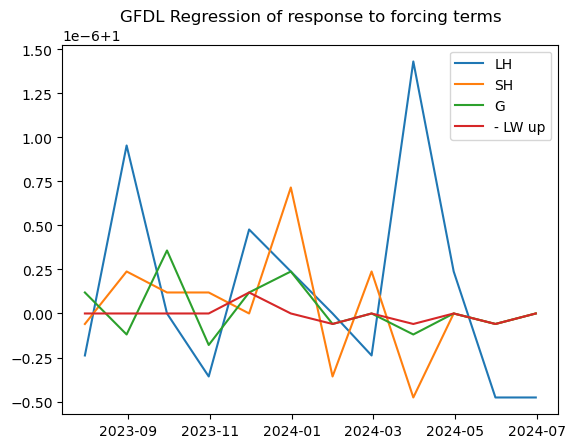

In [51]:
def plot_regression_parameters(data, response_var, predictor_vars):
        hfls_params=list()
        hfss_params = list()
        g_params = list()
        rlus_params = list()
        for month in range(1, 13):
            month_data = data.sel(datetime=data.datetime.dt.month==month)
            X = month_data[predictor_vars].to_dataframe()
            y = month_data[response_var].to_dataframe()
            model = sm.OLS(y, X).fit()
            # print(model.params)
            hfls_params.append(model.params['hfls'])
            hfss_params.append(model.params['hfss'])
            g_params.append(model.params['g'])
            rlus_params.append(model.params['neg_rlus'])
        fig, ax = plt.subplots()
        df = pd.DataFrame({
            'hfls': hfls_params,
            'hfss': hfss_params,
            'g': g_params,
            'neg_rlus': rlus_params
        }, index=pd.date_range(start='2023-07-01', periods=12, freq='M'))
        ax.plot(df['hfls'], label=f'LH')
        ax.plot(df['hfss'], label=f'SH')
        ax.plot(df['g'], label=f'G')
        ax.plot(df['neg_rlus'], label=f'- LW up')
        ax.set_title('GFDL Regression of response to forcing terms')
        ax.legend()
        fig.savefig(f'figs/gfdlresp.png')
        return model.params


model = plot_regression_parameters(gfdl_3hr_new, 'model_response_terms', model_response_vars) 

In [52]:
# this is just a sanity check
seb = obs_3hr['lwdn'] - obs_3hr['lwup'] + obs_3hr['swdn'] - obs_3hr['swup'] - obs_3hr['sh_bulk'] - obs_3hr['lh_grad'] + obs_3hr['cond_flux'] + obs_3hr['storage_flux']
response_terms = obs_3hr['sh_bulk'] + obs_3hr['lh_grad'] + obs_3hr['cond_flux'] + obs_3hr['storage_flux'] - obs_3hr['lwup']
seb 

<xarray.DataArray (datetime: 4368)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2013-01-01 ... 2014-06-30T21:00:00

## Monthly biases

In [ ]:
obs_3hr_path = f"{data_path}/subsetted_obs_3hr.pickle"
with open(obs_3hr_path, 'rb') as handle:
    obs_3hr = pickle.load(handle)
obs_3hr

In [55]:
gfdl_3hr_path = f"{data_path}/subsetted_gfdl_3hr.pickle"
with open(gfdl_3hr_path, 'rb') as handle:
    gfdl_3hr = pickle.load(handle)

# obs
tsurf_month_avg = obs_3hr[['datetime', 'Tsurf']].resample(datetime='1m').mean(dim='datetime')

# model
tslsi_month_avg = gfdl_3hr[['datetime', 'tslsi_C']].resample(datetime='1m').mean(dim='datetime')
# tslsi_month_avg[ 'tslsi_C']

# let's just make sure we're on the same page
time_slice=  slice('2013-07-01', '2014-06-30')
tsurf_month_avg = tsurf_month_avg.sel(datetime = time_slice)
tslsi_month_avg = tslsi_month_avg.sel(datetime = time_slice)
gfdl_3hr = gfdl_3hr.sel(datetime = time_slice)
obs_3hr = obs_3hr.sel(datetime = time_slice)


In [64]:
# takes in list of vars that we should be aggregating to monthly
# assumes that 'datetime' is the time_dimension 
def get_monthly_biases(model, obs, var_model, var_obs):
    result = model.copy()
    # result[var_obs] = obs[var_obs]
    model_vars = ['datetime', var_model]
    obs_vars = ['datetime', var_obs]
    # print(model_vars)
    model_monthly_avg = model[model_vars].resample(datetime='1m').mean(dim='datetime')
    # print(model_monthly_avg[var_model].data)
    obs_monthly_avg = obs[obs_vars].resample(datetime='1m').mean(dim='datetime')
    result[f'{var_model}_bias'] = model_monthly_avg[var_model].data - obs_monthly_avg[var_obs].data
    
    return result

# seb_obs_vars = ['lwdn','lwup', 'swdn' , 'swup' , 'sh_bulk', 'lh_grad', 'cond_flux', 'storage_flux', 'Tsurf', 'lwp']

model_to_obs_var_dict = {
    'rlus':'lwup',
    'rlds':'lwdn',
    'rsus':'swup',
    'rsds':'swdn',
    # 'g':'g',
    'hfss' : 'sh_bulk',
    'hfls':'lh_grad',
    'tslsi_C':'Tsurf'
}

bias_xarray = xr.Dataset()
for key in model_to_obs_var_dict:
    # print(key)
    xr = get_monthly_biases(gfdl_3hr, obs_3hr, key, model_to_obs_var_dict[key])
    bias_xarray[key] = xr[f'{key}_bias'].data
    # print(df[f'{key}_bias'].head(10))
bias_xarray#.to_dataframe().to_latex()

<xarray.Dataset>
Dimensions:  (rlus: 12, rlds: 12, rsus: 12, rsds: 12, hfss: 12, hfls: 12,
              tslsi_C: 12)
Coordinates:
  * rlus     (rlus) float32 12.46 16.17 25.57 -1.919 ... 2.172 35.43 12.83
  * rlds     (rlds) float32 11.28 16.22 24.34 -22.24 ... -2.303 43.69 14.58
  * rsus     (rsus) float32 -39.32 -33.88 -15.85 3.822 ... -12.2 -42.31 -43.7
  * rsds     (rsds) float32 -13.53 -16.56 -5.628 3.637 ... 4.464 -30.68 -21.93
  * hfss     (hfss) float32 8.121 1.897 1.201 -7.579 ... -0.7501 -120.4 -88.46
  * hfls     (hfls) float32 4.197 -0.16 3.03 1.109 ... 1.008 3.359 5.894 5.582
  * tslsi_C  (tslsi_C) float32 2.606 3.629 6.477 -0.7132 ... 0.1365 9.191 2.729
Data variables:
    *empty*

In [66]:
bias_xarray

<xarray.Dataset>
Dimensions:  (rlus: 12, rlds: 12, rsus: 12, rsds: 12, hfss: 12, hfls: 12,
              tslsi_C: 12)
Coordinates:
  * rlus     (rlus) float32 12.46 16.17 25.57 -1.919 ... 2.172 35.43 12.83
  * rlds     (rlds) float32 11.28 16.22 24.34 -22.24 ... -2.303 43.69 14.58
  * rsus     (rsus) float32 -39.32 -33.88 -15.85 3.822 ... -12.2 -42.31 -43.7
  * rsds     (rsds) float32 -13.53 -16.56 -5.628 3.637 ... 4.464 -30.68 -21.93
  * hfss     (hfss) float32 8.121 1.897 1.201 -7.579 ... -0.7501 -120.4 -88.46
  * hfls     (hfls) float32 4.197 -0.16 3.03 1.109 ... 1.008 3.359 5.894 5.582
  * tslsi_C  (tslsi_C) float32 2.606 3.629 6.477 -0.7132 ... 0.1365 9.191 2.729
Data variables:
    *empty*

## Temperature plots

In [67]:
# use Seaborn library to create box and whisker plots by month
# in order to plot multiple datasets, requires combined dataframe with add'l column differentiating data
def sbn_plot_box_whisker_by_month(data, var, title, ylabel, show_outliers=True):
    fig, axes = plt.subplots()
    # Create the boxplot
    ax = sns.boxplot(data=data, x=data['datetime'].dt.strftime("%B").values, y=var, orient="v", hue='dataset', showfliers = show_outliers) 
    ax.set_xticks(np.arange(0, 12))
    ax.set_xticklabels(data['datetime'].dt.strftime("%B").values, rotation=45, ha='right')
    ax.set_xlabel('July 2013 - August 2014')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Month')
    fig.savefig(f'figs/{title}.png')


# combine everything into 1 nice dataframe for plotting
def combine_dataframes(model, model_var_name, obs, obs_var_name, new_var_name):
    df1 = model[model_var_name].to_dataframe().reset_index()
    df2 = obs[obs_var_name].to_dataframe().reset_index()
    
    df1['dataset'] = 'GFDL'
    df1[new_var_name] = model[model_var_name]
    
    df2[new_var_name] = obs[obs_var_name]
    df2['dataset'] = 'Obs'
    
    combined_df = pd.concat([df1, df2], keys=['datetime', new_var_name, 'dataset'])
    return combined_df

In [68]:
## Bias
monthly_biases = (tslsi_month_avg['tslsi_C']-tsurf_month_avg['Tsurf'] )
print(monthly_biases)
overall_bias = np.nanmean(monthly_biases)
print(overall_bias)

# summer - # only consider JJA
summer_rmse = np.nanmean([monthly_biases[0], monthly_biases[1], 
                          #monthly_biases[2], monthly_biases[3], monthly_biases[10], 
    monthly_biases[11] ])
print(summer_rmse)

# winter - # only condider DJF
winter_rmse = np.nanmean( #monthly_biases[4],
    [monthly_biases[5], monthly_biases[6], monthly_biases[7]] #monthly_biases[8], monthly_biases[9] ]
    )
print(winter_rmse)

<xarray.DataArray (datetime: 12)>
array([  2.6060276 ,   3.6288395 ,   6.477066  ,  -0.7132416 ,
        -1.5956459 ,   9.055412  , -12.047291  ,  -4.1336746 ,
        -3.5645905 ,   0.13645935,   9.19146   ,   2.7290955 ],
      dtype=float32)
Coordinates:
    height    float64 2.0
  * datetime  (datetime) datetime64[ns] 2013-07-31 2013-08-31 ... 2014-06-30
0.9808264
2.9879875
-2.3751843


In [69]:
mean_bias = np.nanmean( (gfdl_3hr['tslsi_C'] - obs_3hr['Tsurf']) )

difference = (obs_3hr['Tsurf'] - (gfdl_3hr['tslsi_C']))
# difference
monthly_mean_difference = difference.groupby('datetime.month').mean('datetime')
monthly_mean_difference

<xarray.DataArray (month: 12)>
array([12.047291  ,  4.1336775 ,  3.5645885 , -0.13645795, -9.5682335 ,
       -2.6960068 , -2.606028  , -3.6288397 , -6.477066  ,  0.7132507 ,
        1.5956504 , -9.055411  ], dtype=float32)
Coordinates:
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

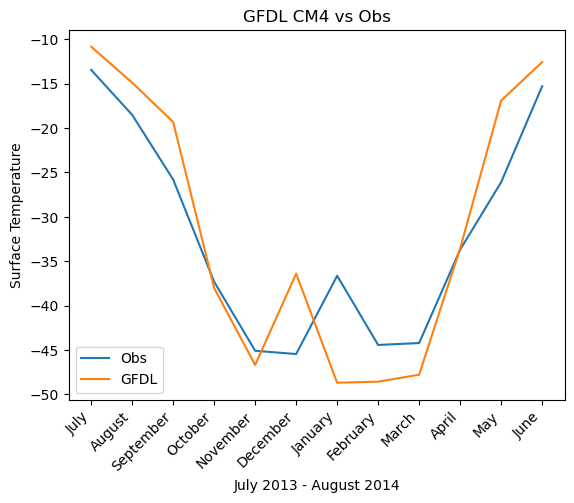

In [70]:
fig, ax = plt.subplots()
ax.plot(tsurf_month_avg['Tsurf'].values, label='Obs')
ax.plot(np.arange(0, 12), tslsi_month_avg['tslsi_C'].values, label='GFDL')
ax.set_xticks(np.arange(0, 12))
ax.set_xticklabels(tsurf_month_avg['datetime'].dt.strftime("%B").values, rotation=45, ha='right')
ax.set_xlabel('July 2013 - August 2014')
ax.set_ylabel('Surface Temperature')
ax.set_title('GFDL CM4 vs Obs')
ax.legend()
plt.show()
fig.savefig(f'figs/Surface Temperature.png')

In [ ]:
combined_df = combine_dataframes(gfdl_3hr, 'tslsi_C', obs_3hr, 'Tsurf', 'T')
sbn_plot_box_whisker_by_month(combined_df, 'T', 'July 2013 - August 2014 Surface Temperature', 'Degrees Celsius', True) 

## LW DOWN

In [ ]:
# lwdn - lwup + swdn - swup - sh_bulk(or sh_cv if avail.) - lh_grad + cond_flux + storage_flux
# seb_obs_vars = ['lwdn','lwup'  'swdn' , 'swup' , 'sh_bulk', 'lh_grad', 'cond_flux', 'storage_flux', 'Tsurf', 'lwp']
# ['hfls', 'hfss', 'rlds', 'rlus', 'rsds', 'rsus', 'tslsi']

combined_df = combine_dataframes(gfdl_3hr, 'rlds', obs_3hr, 'lwdn', 'lwdn')
sbn_plot_box_whisker_by_month(combined_df, 'lwdn', 'July 2013 - August 2014 LW Down', '$W/m^2$') 

## LW UP

In [ ]:
combined_df = combine_dataframes(gfdl_3hr, 'rlus', obs_3hr, 'lwup', 'lwup')
sbn_plot_box_whisker_by_month(combined_df, 'lwup', 'July 2013 - August 2014 LW UP', '$W/m^2$') 

## SW DOWN

In [ ]:
combined_df = combine_dataframes(gfdl_3hr, 'rsds', obs_3hr, 'swdn', 'swdn')
sbn_plot_box_whisker_by_month(combined_df, 'swdn', 'July 2013 - August 2014 SW Down', '$W/m^2$') 

## SW UP

In [ ]:
combined_df = combine_dataframes(gfdl_3hr, 'rsus', obs_3hr, 'swup', 'swup')
sbn_plot_box_whisker_by_month(combined_df, 'swup', 'July 2013 - August 2014 SW Up', '$W/m^2$') 

## SH

In [ ]:
combined_df = combine_dataframes(gfdl_3hr, 'hfss', obs_3hr, 'sh_bulk', 'sh')
sbn_plot_box_whisker_by_month(combined_df, 'sh', 'July 2013 - August 2014 Sensible Heat', '$W/m^2$', show_outliers=False) 

## LH

In [ ]:
combined_df = combine_dataframes(gfdl_3hr, 'hfls', obs_3hr, 'lh_grad', 'lh')
sbn_plot_box_whisker_by_month(combined_df, 'lh', 'July 2013 - August 2014 Latent Heat', '$W/m^2$', show_outliers=False) 